# Set up the environment

## Install packages

## Import packages

In [ ]:
import scanpy as sc
import muon as mu
import torch
import scipy as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from muon import atac as ac

sns.set_theme(style="white")

## Helping functions

## Load data

In [2]:
adata = sc.read_h5ad("data/pbmc10k_atac.h5ad")
adata

AnnData object with n_obs × n_vars = 10650 × 374189
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
    layers: 'binary'

# EDA

Let's take a look at the data first

## Peak statistics

In [3]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# Rename columns
adata.obs.rename(
    columns={
        "n_genes_by_counts": "n_features_per_cell",
        "total_counts": "total_fragment_counts",
    },
    inplace=True,
)

# Rename columns
adata.var.rename(
    columns={
        "n_cells_by_counts": "n_cells_per_feature",
    },
    inplace=True,
)

adata

AnnData object with n_obs × n_vars = 10650 × 374189
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'n_features_per_cell', 'total_fragment_counts'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'binary'

<Axes: xlabel='n_cells_per_feature', ylabel='Count'>

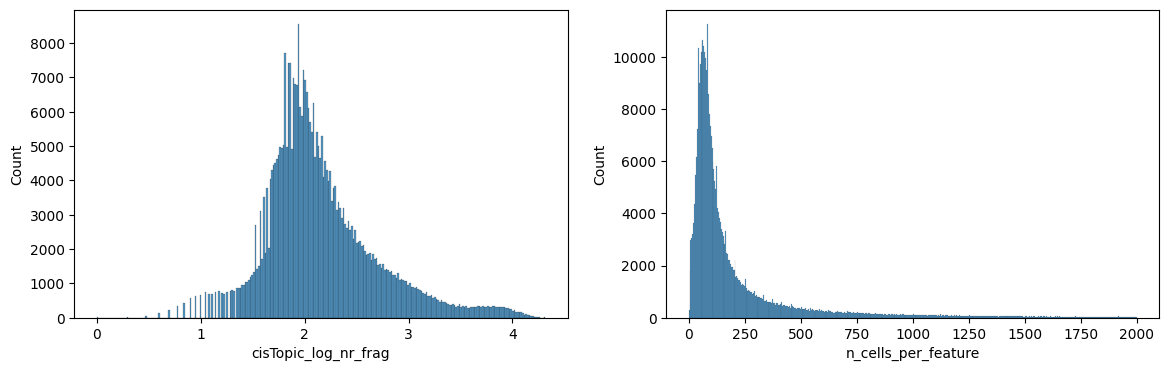

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(adata.var, x="cisTopic_log_nr_frag", ax=ax1)
sns.histplot(adata.var, x="n_cells_per_feature", ax=ax2, binrange=(0, 2000))

## Cell statistics

<Axes: xlabel='tss_enrichment', ylabel='Count'>

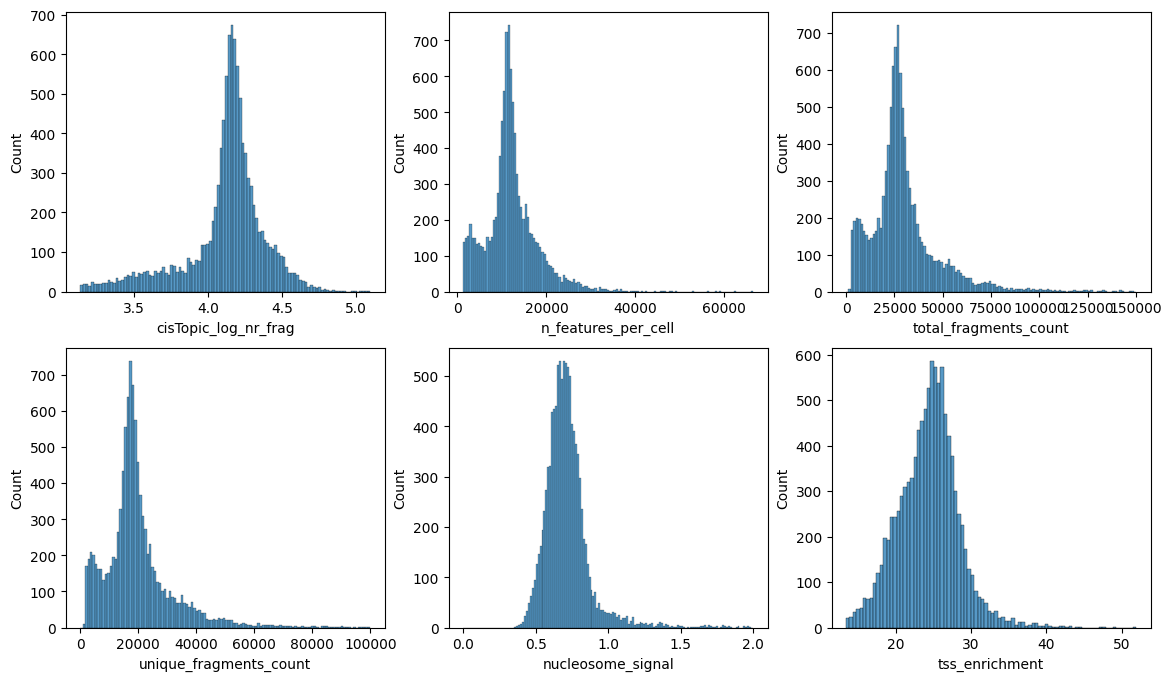

In [5]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))

sns.histplot(adata.obs, x="cisTopic_log_nr_frag", ax=ax1)
sns.histplot(adata.obs, x="n_features_per_cell", ax=ax2)
sns.histplot(adata.obs, x="total_fragments_count", ax=ax3, binrange=(0, 150000))
sns.histplot(adata.obs, x="unique_fragments_count", ax=ax4, binrange=(0, 100000))
sns.histplot(adata.obs, x="nucleosome_signal", ax=ax5, binrange=(0, 2))
sns.histplot(adata.obs, x="tss_enrichment", ax=ax6)

## Filter cells and peaks

In [6]:
mu.pp.filter_var(adata, 'n_cells_per_feature', lambda x: (x >= 70) & (x <= 9000))
mu.pp.filter_obs(adata, 'n_features_per_cell', lambda x: (x >= 500) & (x <= 25000))
mu.pp.filter_obs(adata, 'nucleosome_signal', lambda x: x <= 1.3)

In [7]:
adata

AnnData object with n_obs × n_vars = 10126 × 264916
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'n_features_per_cell', 'total_fragment_counts'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'binary'

## Visualize cells

In [8]:
# Save original counts
adata.layers["counts"] = adata.X.copy()

In [9]:
# Normalize
ac.pp.tfidf(adata, scale_factor=1e4)

In [10]:
# Dimensionality reduction
ac.tl.lsi(adata)

In [11]:
# Find neighbors
sc.pp.neighbors(adata, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

In [12]:
# Calculate clusters
sc.tl.leiden(adata, resolution=.5, flavor="igraph", n_iterations=2)

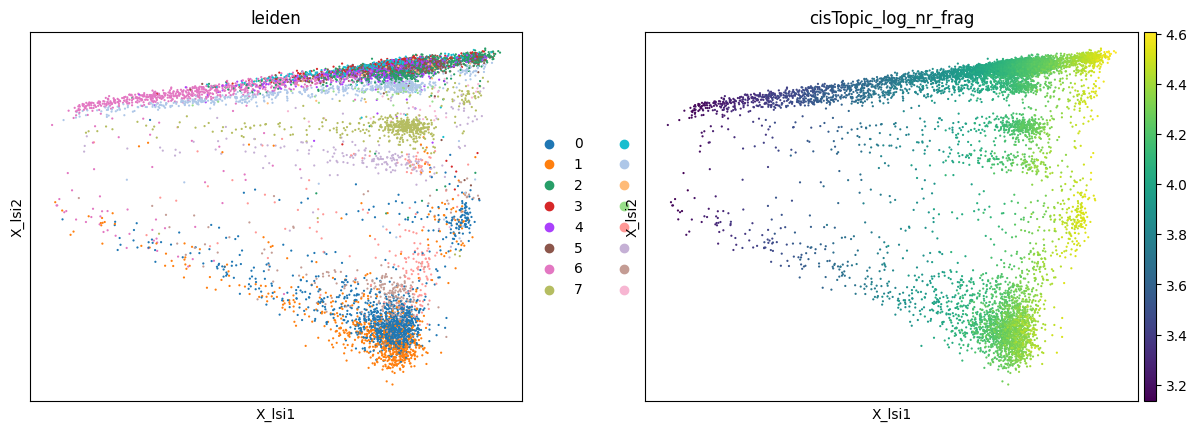

In [13]:
sc.pl.embedding(adata, basis="X_lsi", color=["leiden", "cisTopic_log_nr_frag"],  size=10)

In [14]:
# Calculate UMAP
sc.tl.umap(adata, random_state=4)

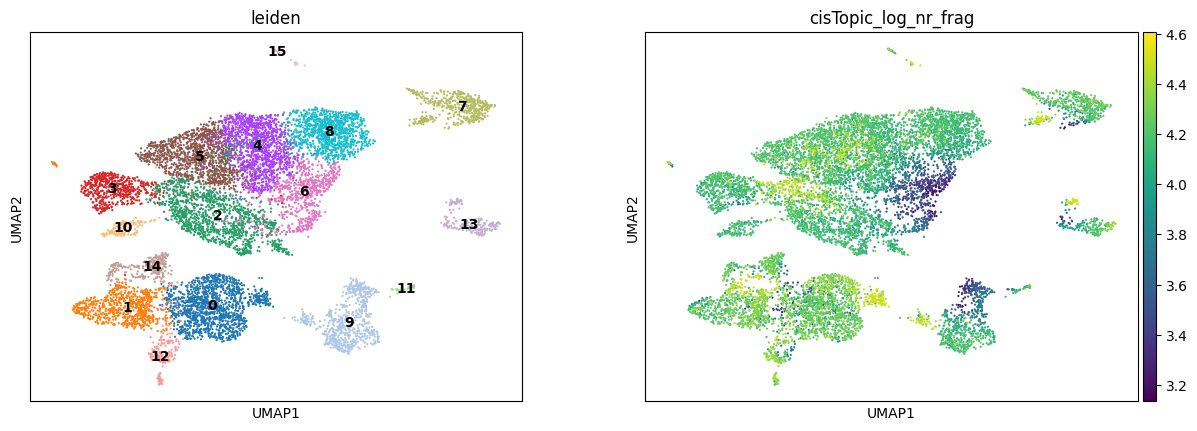

In [15]:
sc.pl.umap(adata, color=["leiden", "cisTopic_log_nr_frag"], size=10, legend_loc="on data")

## Visualise peaks

In [16]:
adata_peaks = adata.transpose().copy()
adata_peaks

AnnData object with n_obs × n_vars = 264916 × 10126
    obs: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    var: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'n_features_per_cell', 'total_fragment_counts', 'leiden'
    uns: 'lsi', 'neighbors', 'leiden', 'leiden_

In [17]:
# Find neighbors
sc.pp.neighbors(adata_peaks, use_rep="LSI", n_neighbors=15, n_pcs=50)

In [18]:
# Calculate clusters
sc.tl.leiden(adata_peaks, resolution=.5, flavor="igraph", n_iterations=2)

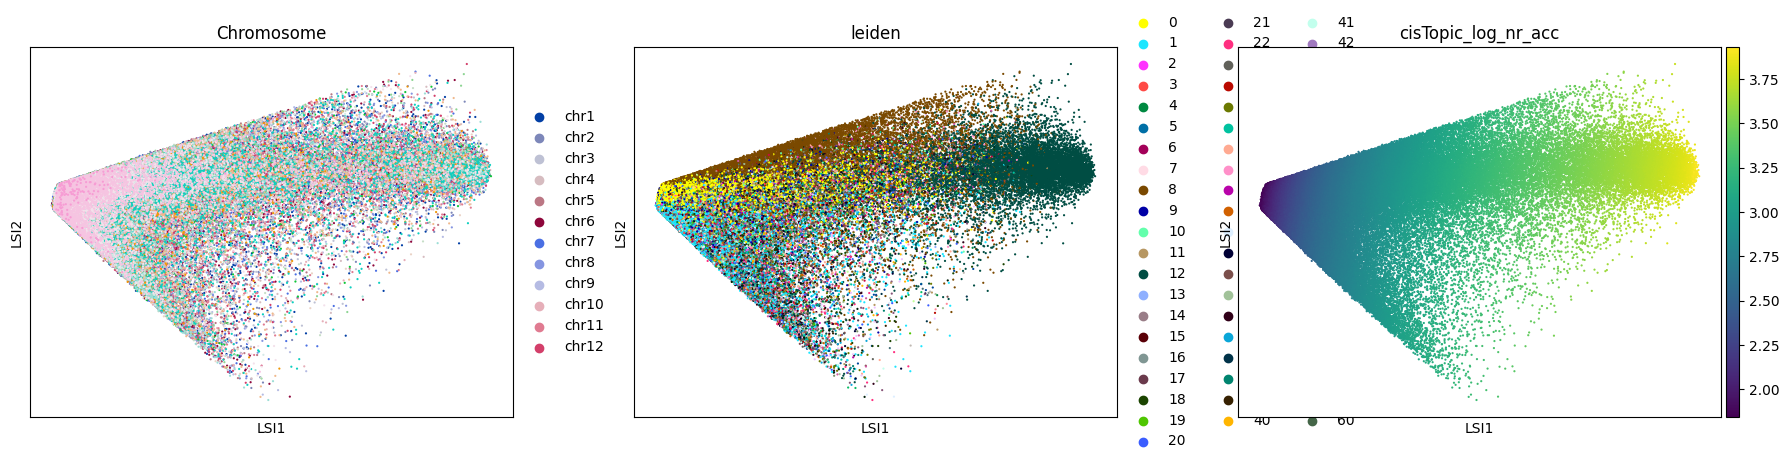

In [19]:
sc.pl.embedding(adata_peaks, basis="LSI", color=["Chromosome", "leiden", "cisTopic_log_nr_acc"],  size=10)

In [20]:
# Calculate UMAP
sc.tl.umap(adata_peaks, random_state=4)

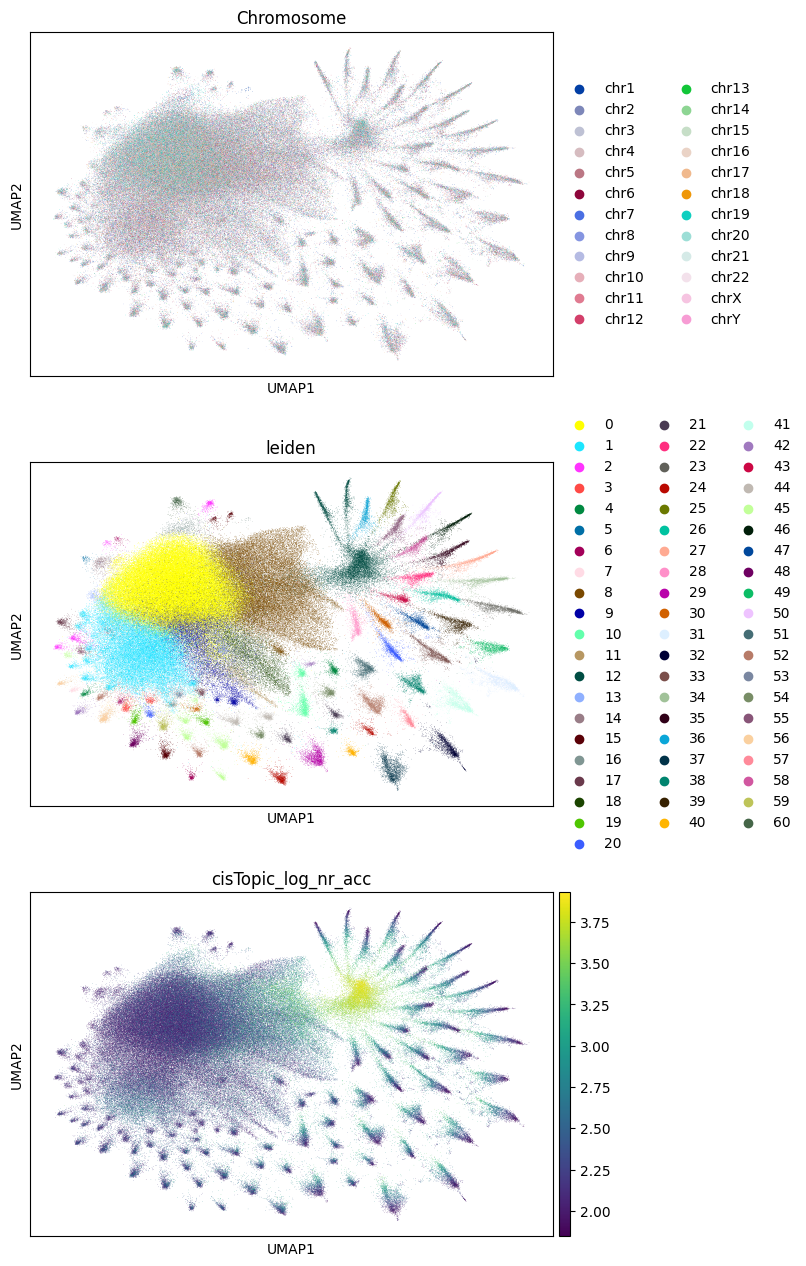

In [21]:
sc.pl.umap(adata_peaks, color=["Chromosome", "leiden", "cisTopic_log_nr_acc"], ncols=1)

## Save eda objects

In [22]:
adata.write("data/pbmc10k_eda.h5ad")
adata_peaks.write("data/pbmc10k_peaks_eda.h5ad")